In [19]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [20]:
import transformers
print(transformers.__version__)

In [3]:
%pip install transformers --upgrade

  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 43.2 MB/s eta 0:00:00
  Using cached tokenizers-0.13.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
from transformers import DebertaTokenizerFast, TFDebertaModel

In [22]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])


In [23]:
ratingsnew = ratings_.head(10000)
# ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1))

/tmp/ipykernel_24713/3368612200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingsnew['text'] = ratingsnew['text'].astype(str)


In [24]:
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


/tmp/ipykernel_24713/2687010449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
/tmp/ipykernel_24713/2687010449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [25]:
sparse_item_user = sparse.csr_matrix((df_features['stars'].astype('float'), (df_features['user_id'], df_features['business_id'])))
sparse_user_item = sparse.csr_matrix((df_features['stars'].astype('float'),  (df_features['business_id'],df_features['user_id'])))


In [11]:
%pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 19.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
import implicit

In [27]:
modelRec = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)


alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')


modelRec.fit(data_conf)


100%|██████████| 20/20 [00:00<00:00, 329.45it/s]


In [28]:
df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)
df_features.head()

/tmp/ipykernel_24713/3483575756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)


,user_id,business_id,stars,text,labels
0,7445,2091,3.0,"[CLS] If you decide to eat here , just be awar...","[-1.3565356, -0.03497186, 1.2590424, -1.082594..."
1,3849,525,5.0,[CLS] I ' ve taken a lot of spin classes over ...,"[-0.23942278, -1.6310798, 0.76873416, 2.037454..."
2,1395,2179,3.0,[CLS] Family diner . Had the b ##uff ##et . E ...,"[-0.07545243, -0.03888188, -0.0024772896, -0.0..."
3,5467,2992,5.0,"[CLS] Wow ! Yu ##mmy , different , delicious ....","[-1.1206474, -1.3881706, 0.5525984, -0.5197498..."
4,5864,2555,4.0,[CLS] Cut ##e interior and owner ( ? ) gave us...,"[-0.64282215, 0.9417535, -0.6517764, 1.5099511..."


In [29]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)
y_train = tf.convert_to_tensor(
    train_df["labels"].tolist(), dtype=float
)

y_test = tf.convert_to_tensor(
    test_df["labels"].tolist(), dtype=float
)


In [30]:
tokenizer = DebertaTokenizerFast.from_pretrained('microsoft/deberta-base')
debertaBert = TFDebertaModel.from_pretrained('microsoft/deberta-base')

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [31]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=120,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [32]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [33]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [34]:
max_len = 120
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = debertaBert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'linear')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [37]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = MeanSquaredError()
metric = MeanSquaredError()
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [MeanSquaredError(),MeanAbsolutePercentageError()])

In [38]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
223/223 [==============================] - 1473s 6s/step - loss: 1.1334 - mean_squared_error: 1.1340 - mean_absolute_percentage_error: 8279382.0000 - val_loss: 1.1073 - val_mean_squared_error: 1.1075 - val_mean_absolute_percentage_error: 8809984.0000
Epoch 2/2
223/223 [==============================] - 1427s 6s/step - loss: 1.1146 - mean_squared_error: 1.1145 - mean_absolute_percentage_error: 9312966.0000 - val_loss: 1.1059 - val_mean_squared_error: 1.1060 - val_mean_absolute_percentage_error: 9273297.0000


In [39]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

250/250 [==============================] - 318s 1s/step


array([-0.02401698,  0.13088457,  0.19292153,  0.26168817,  0.23475948,
        0.32539696, -0.00720732,  0.14552552,  0.05948967,  0.13752146,
        0.15749821,  0.1301346 ,  0.1441576 ,  0.19999973,  0.2169731 ,
        0.25880355,  0.20896824,  0.11983024,  0.08634098,  0.15727244],
      dtype=float32)

In [40]:
y_train[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-1.5919253 , -1.040932  , -0.09627575,  2.209613  ,  0.91369885,
        2.225478  ,  0.1424232 ,  1.816099  , -1.1169858 ,  0.9107975 ,
       -0.02778556,  0.89377743, -0.33357757,  1.2678132 , -1.0405133 ,
       -1.347721  ,  0.0181216 , -0.660349  , -0.26294014,  1.3509326 ],
      dtype=float32)>

In [41]:
train_history.history

{'loss': [1.1333649158477783, 1.1146273612976074],
 'mean_squared_error': [1.1340060234069824, 1.114458680152893],
 'mean_absolute_percentage_error': [8279382.0, 9312966.0],
 'val_loss': [1.107349157333374, 1.1058799028396606],
 'val_mean_squared_error': [1.107452154159546, 1.1059629917144775],
 'val_mean_absolute_percentage_error': [8809984.0, 9273297.0]}

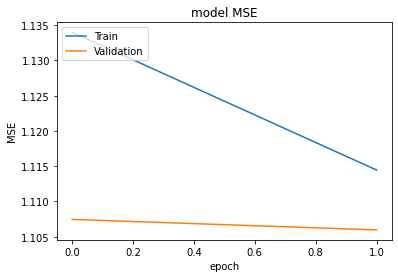

In [42]:
plt.plot(train_history.history['mean_squared_error'])
plt.plot(train_history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
user_id = test_df['user_id'].tolist()[0]
print(user_id)


9383


In [44]:
newVector = np.array(predicted_raw[0])
print(newVector)
modelRec.user_factors[user_id]

[-0.02401698  0.13088457  0.19292153  0.26168817  0.23475948  0.32539696
 -0.00720732  0.14552552  0.05948967  0.13752146  0.15749821  0.1301346
  0.1441576   0.19999973  0.2169731   0.25880355  0.20896824  0.11983024
  0.08634098  0.15727244]


array([ 0.12402124, -0.62874126, -0.09282583, -0.7370085 ,  2.6382432 ,
       -0.20067959,  0.20862514,  3.088294  ,  2.7515104 , -1.1137679 ,
       -1.4830273 ,  0.05226371,  1.9869531 ,  1.4972224 ,  1.7287437 ,
        0.77877915,  0.6526263 ,  0.9462281 , -2.3563461 ,  1.609702  ],
      dtype=float32)

In [45]:
modelRec.recommend(user_id,data_conf[user_id], N = 20)

(array([1600, 2466, 2589, 1998,  462, 2237, 3082,  900, 3602,  630, 2383,
        3422, 3686, 2759,  859, 3133, 3015,  705, 3152,  988], dtype=int32),
 array([1.1322532 , 1.0117424 , 0.8326085 , 0.7217466 , 0.69644755,
        0.6713348 , 0.6505662 , 0.6139205 , 0.5803361 , 0.559798  ,
        0.5574723 , 0.5148183 , 0.4948058 , 0.49312988, 0.49162775,
        0.48619542, 0.47922128, 0.46713504, 0.46702182, 0.45811465],
       dtype=float32))

In [46]:
modelRec.user_factors[user_id] = newVector
print(modelRec.recommend(user_id,data_conf[user_id], N =20))

(array([2866, 1442, 1415,  752, 3530, 3639, 1069, 1291, 2615,  456,  365,
       2883, 1448,   30, 3376, 3653,  921, 2589,  900, 1898], dtype=int32), array([0.07430903, 0.06721484, 0.06637412, 0.05944141, 0.0588606 ,
       0.0583311 , 0.0582436 , 0.05810701, 0.05808962, 0.05751678,
       0.05740892, 0.05608143, 0.05586857, 0.05544337, 0.05524411,
       0.05510059, 0.05357487, 0.05218003, 0.05179946, 0.05095629],
      dtype=float32))
